In [1]:
import os
import pandas as pd
import numpy as np
import fitsio
import cudf
from numba import cuda
import cupy as cp
from pathlib import Path, PurePath
import matplotlib.pyplot as plt

In [20]:
def get_dist_mat(coords):
    # Calculate distance matrix for a series of 1D coordinates by converting to 2D for a 4096 x 4096 image array. 

    # Unravel the coordinates (np.unravel_index() is much slower than this...)
    coords_x = coords % 4096
    coords_y = coords // 4096
    # Prepare for broadcasting. 
    coords_xb = coords_x[:, np.newaxis]
    coords_yb = coords_y[:, np.newaxis]
    # Compute distance matrix.  
    dx_broadc = coords_x - coords_xb
    dy_broadc = coords_y - coords_yb
    dist_matrix = dx_broadc**2 + dy_broadc**2
    return dist_matrix


def get_rows_list(array, w1_idx, w2_idx):
    # Get the row indices in `array` for coordinates within an 8-connectivity neighbourhood (1 pixel away from each other at most) 
    # for the 2 given wavelength (w1_idx, w2_idx)
 
    np_mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = np.nonzero(np_mask)[0]
    coords = array[np_mask, 0]
    dist_matrix = get_dist_mat(coords)
    select = dist_matrix < 2 
    select2 = np.triu(select, k=1)
    r,c = np.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2


def get_2clusters(array, w1_idx, w2_idx, group_n=None):
    # Build the dataframe of clusters of 2 nearest neighbours across 2 different wavelengths
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    records = np.concatenate((array[idx1, 0:4], array[idx2, 0:4]), axis=1)
    df_records = pd.DataFrame(records, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    if group_n is not None:
        df_records['GroupNumber'] = group_n
    
    return df_records

### Load the parquet file listing all the groups of 7 files with their timestamps. 

In [9]:
data_dir = os.environ['SPIKESDATA']
spikes_db = pd.read_parquet(os.path.join(data_dir, 'spikes_df_2010.parquet'), columns=['GroupNumber', 'Time'], engine='pyarrow')
spikes_db.head(14)

GroupNumber                             Time
0             0 2010-05-13 00:00:02.090000+00:00
1             0 2010-05-13 00:00:03.570000+00:00
2             0 2010-05-13 00:00:05.070000+00:00
3             0 2010-05-13 00:00:06.580000+00:00
4             0 2010-05-13 00:00:08.080000+00:00
5             0 2010-05-13 00:00:09.580000+00:00
6             0 2010-05-13 00:00:11.080000+00:00
7             1 2010-05-13 00:00:14.080000+00:00
8             1 2010-05-13 00:00:15.580000+00:00
9             1 2010-05-13 00:00:17.080000+00:00
10            1 2010-05-13 00:00:18.580000+00:00
11            1 2010-05-13 00:00:20.090000+00:00
12            1 2010-05-13 00:00:21.580000+00:00
13            1 2010-05-13 00:00:23.070000+00:00

### Map the group number to a timestamp. Arbitrary choice: choose the 1st file in the group. 

In [11]:
gdates = spikes_db.groupby('GroupNumber').nth(0)
print(len(gdates))
gdates.head()

1634668


Time
GroupNumber                                 
0           2010-05-13 00:00:02.090000+00:00
1           2010-05-13 00:00:14.080000+00:00
2           2010-05-13 00:00:26.080000+00:00
3           2010-05-13 00:00:38.080000+00:00
4           2010-05-13 00:00:50.080000+00:00

### Load a parquet file (1 day of data). This is the result of the preprocessing that runs through all the individual fits files to only keep those coordinates where at least one nearest neighbour was found in any of the 6 other wavelengths. 

The index (GroupNumber) map to a timestamp. Same GroupNumber are for observations taken at the same time. 

#### columns are: 
- coords:1D coordinates of a 4096 x 4096 image array
- int1, int2: intensity before interpolation, intensity after interpolation
- wref: reference wavelength number of that coordinate (from 0 to 6)
- w0, ... w6: binary (1 or 0) telling whether that coordinate has a nearest neighbour in those wavelengths. 

If for a given coordinate wref = 3, then by definition w3 = 1, and there will be at least one the other wavelength with a True value (1), and that "conjugate" or "neighbour" will be found somehwere further down that list and sharing the same GroupNumber (as it belonged to the same file recorded at the same time). 

In [19]:
parquet_dir = os.path.expanduser('~/raphael/data/AIA_Spikes/parquet_dataframes2')
df0 = pd.read_parquet(PurePath(parquet_dir, '2010/06/df_coincidentals_2010_06_13.parquet'), engine='pyarrow')
df0.set_index('GroupNumber', inplace=True)
# Get some examples of few spikes coordinates within the same group (a given group has thousands of rows typically)
df0.iloc[0:10]

coords  int1  int2  wref  w0  w1  w2  w3  w4  w5  w6
GroupNumber                                                      
223200        11121   212    10     0   1   0   0   1   0   0   0
223200        22174    49    12     0   1   0   0   0   0   0   1
223200        39005   236    15     0   1   1   0   0   0   0   0
223200        43101   215    14     0   1   1   0   0   0   0   0
223200        84607    96    10     0   1   0   0   0   0   0   1
223200        85031    60     6     0   1   0   1   0   0   0   0
223200       108490    65    16     0   1   0   0   1   0   0   0
223200       112586    75    14     0   1   0   0   1   0   0   0
223200       124759   273    14     0   1   0   0   0   0   0   1
223200       128854   187    14     0   1   0   0   0   0   0   1

### Out of these data above, we want to collect all blobs of spatially connected pixels with 8-connectivity for a given combination of wavelengths. We don't want to compute and store all of them, but being able to ask for one of the combination. At this stage, intensity is a dimension that is not relevant and not used for now. 

E.g: What are the cluster of coordinates within 1 pixel of each other observed with a given combination of wavelengths
- (w0, w1, w2)
- (w0, w1, w3)
- (w0, w1, w4)
- (w0, w3, w5, w6)
- ...
- {w0, w1, w3, w4, w5, w6, w7}

### Down below are some easy statistics

In [21]:
c = df0.groupby(level=0).size().rename('total count (>= 2-wavelength-overlaps)')
c.head()

GroupNumber
223200    8602
223201    8436
223202    8589
223203    8251
223204    8784
Name: total count (>= 2-wavelength-overlaps), dtype: int64

In [33]:
# Get the number of wavelengths involved in the 8-connectivity and add it to the dataframe
seriesccount = df0[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6']].sum(axis=1).rename('overlaps')

In [34]:
# Add this to the dataframe
df0['overlaps'] = seriesccount
seriesccount.head()
print(len(df0.loc[seriesccount==5]))
df0.loc[seriesccount==3].head()

618


coords  int1  int2  wref  w0  w1  w2  w3  w4  w5  w6  overlaps
GroupNumber                                                                  
223200         844744    72    10     0   1   0   1   0   0   1   0         3
223200        2154952    86    10     0   1   0   1   0   0   1   0         3
223200        5517354    86    18     0   1   0   0   0   0   1   1         3
223200       11935629    42    16     0   1   1   0   0   1   0   0         3
223200       12455438   156    42     0   1   0   0   0   0   1   1         3

In [40]:
# Get how many spikes coordinates are connected to other spikes coordinates across exactly 3 different wavelengths in each group
# (again, all of this happens in an 8-connectivity)
c3 = df0.loc[df0['overlaps']==3].groupby(level=0).size().rename('count for 3-wavelength-connectivity')
c3.head()

GroupNumber
223200    218
223201    201
223202    185
223203    278
223204    171
Name: count for 3-wavelength-connectivity, dtype: int64

In [41]:
# Add this to the previous statistics and map that to the actual timestamps
dfcount = pd.concat([gdates.loc[c.index], c, c3], axis=1)
dfcount.set_index('Time', inplace=True)
dfcount.head()

total count (>= 2-wavelength-overlaps)  \
Time                                                                       
2010-06-13 00:00:00.580000+00:00                                    8602   
2010-06-13 00:00:12.550000+00:00                                    8436   
2010-06-13 00:00:24.580000+00:00                                    8589   
2010-06-13 00:00:36.570000+00:00                                    8251   
2010-06-13 00:00:48.570000+00:00                                    8784   

                                  count for 3-wavelength-connectivity  
Time                                                                   
2010-06-13 00:00:00.580000+00:00                                218.0  
2010-06-13 00:00:12.550000+00:00                                201.0  
2010-06-13 00:00:24.580000+00:00                                185.0  
2010-06-13 00:00:36.570000+00:00                                278.0  
2010-06-13 00:00:48.570000+00:00                                171.0

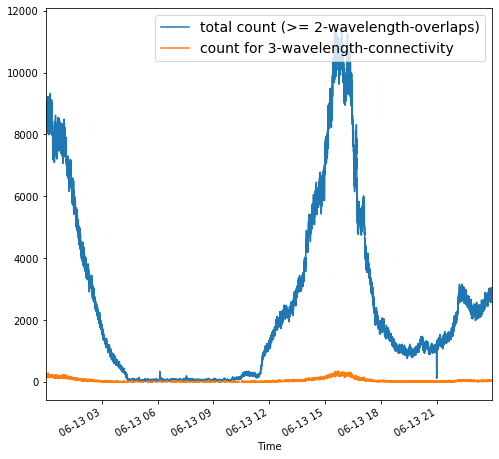

In [42]:
%matplotlib inline
dfcount.plot(figsize=(8,8))
plt.legend(fontsize=14)

### Design method to extract unique coincidental events, lifting any ambiguity (conjugates, redundancies, ...)

This is only a partitionning for a given combination of 2 wavelengths, effectively giving cluster of only 2 connected pixels across 2 wavelengths, this is not an actual "clustering algorithm" per se, as this will only work for pairs. 

In [49]:
# Get the column index for some of the wavelengths
w1_idx = 4
w2_idx = 5
w3_idx = 6
w4_idx = 7

In [50]:
# Get some the group numbers in a non-redundant list for sake of simplicity
groups = df0.index.unique()

In [46]:
# Example of info related to clusters of 2 pixels in wavelength
events12 = [get_2clusters(df0.loc[group_n].values, w1_idx, w2_idx, group_n) for group_n in groups]
df_events12 = pd.concat(events12)
df_events12 = df_events12.loc[(df_events12.wref2 == 1)]
print(len(events12))
df_events12.head()

7199


coords1  int1_before  int1_after  wref1  coords2  int2_before  int2_after  \
1    39005          236          15      0    43101           59           2   
3    43101          215          14      0    43100          207           2   
4    43101          215          14      0    47197          235           2   
5    43101          215          14      0    43101           59           2   
6   321131           60          11      0   321132           19           3   

   wref2  GroupNumber  
1      1       223200  
3      1       223200  
4      1       223200  
5      1       223200  
6      1       223200

In [54]:
# Same as above for amother combination of 2 wavelengths
events14 = [get_2clusters(df0.loc[group_n].values, w1_idx, w4_idx, group_n) for group_n in groups]
df_events14 = pd.concat(events14)
df_events14 = df_events14.loc[(df_events14.wref2 == 3)]
df_events14.head()

coords1  int1_before  int1_after  wref1  coords2  int2_before  int2_after  \
1    11121          212          10      0    15217           99          -1   
3   108490           65          16      0   112586           56           0   
4   112586           75          14      0   112585           53           0   
5   112586           75          14      0   112586           56           0   
6   112586           75          14      0   116682           32           0   

   wref2  GroupNumber  
1      3       223200  
3      3       223200  
4      3       223200  
5      3       223200  
6      3       223200

In [57]:
# Get a count of those for each group number, map to their time stamp and plot that for the entire day
c12 = df_events12.groupby('GroupNumber').size().rename('coincidentals count for Wav 0 & Wav 1')
dfcount12 = pd.concat([gdates.loc[groups], c12], axis=1)
dfcount12.set_index('Time', inplace=True)

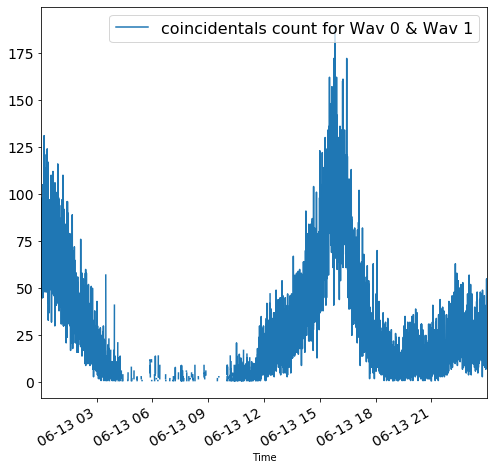

In [58]:
%matplotlib inline
ax = dfcount12.plot(figsize=(8,8), fontsize=14)
ax.legend(fontsize=16)

### Plot some of these occurence for the 1st group on the actual solar disk

In [62]:
r_sun = 1578
crpix = 2048.5
nx = 4096
ny = 4096

In [63]:
coords1 = df_events12.loc[df_events12['GroupNumber']==groups[0]]['coords1'].values
coords_x1 = coords1 % 4096
coords_y1 = coords1 // 4096

coords2 = df_events12.loc[df_events12['GroupNumber']==groups[0]]['coords2'].values
coords_x2 = coords2 % 4096
coords_y2 = coords2 // 4096

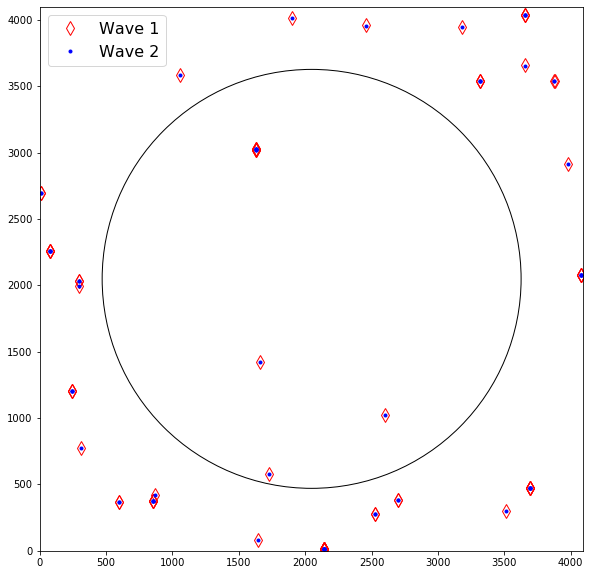

In [64]:
sdisk = plt.Circle((crpix, crpix), r_sun, color='black', fill=False)
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
ax.add_artist(sdisk)
plt.plot(coords_x1, coords_y1, 'rd', ms=10, markerfacecolor='none', label='Wave 1')
plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
plt.legend(fontsize=16)